## Deep Learning Stock Trading Simulate

[Train](#Train)  
[Evaluate](#Evaluate)

### Train Test

In [2]:

import pandas as pd
import numpy as np
import importlib
import sys
import tqdm
import logging
# from utils import *

from importlib import reload

import utility.utils
reload(utility.utils)
from utility.utils import *

import utility.action
reload(utility.action)
from utility.action import *

pd.set_option('display.float_format', lambda x: '%.4f' % x)
model_name = 'DQN'
stock_name = '0050_2013'
window_size = 10
num_episode = 5
initial_balance = 50000

stock_data = stock_sigmoids(stock_name)
stock_prices = stock_close_prices(stock_name)
stock_margin = stock_margins(stock_name)
trading_period = len(stock_prices) - 1  # 訓練期間，input stock data的總日期
returns_across_episodes = []
num_experience_replay = 0
action_dict = {0: 'Hold', 1: 'Buy', 2: 'Sell'}

logging.basicConfig(filename=f'logs/{model_name}_training_{stock_name}.log', filemode='w',
                    format='[%(asctime)s.%(msecs)03d %(filename)s:%(lineno)3s] %(message)s', 
                    datefmt='%m/%d/%Y %H:%M:%S', level=logging.INFO)

logging.info(f'Trading Object:           {stock_name}')
logging.info(f'Trading Period:           {trading_period} days')
logging.info(f'Window Size:              {window_size} days')
logging.info(f'Training Episode:         {num_episode}')
logging.info(f'Model Name:               {model_name}')
logging.info('Initial Portfolio Value: ${:,}'.format(initial_balance))

# select learning model
model = importlib.import_module(f'agents.{model_name}')
agent = model.Agent(state_dim=13 + 3, balance=initial_balance,model_name=model_name)

In [2]:

import utility.utils
reload(utility.utils)
from utility.utils import *

import utility.action
reload(utility.action)
from utility.action import *

for e in tqdm.tqdm(range(1, num_episode + 1)):
    logging.info(f'\nEpisode: {e}/{num_episode}')

    agent.reset() # reset to initial balance and hyperparameters
    state = generate_combined_state(0, window_size, stock_prices, stock_margin, agent.balance, len(agent.inventory)) 
    # 將prince_state與portfolio_state 橫向串連起來橫向串連，作為input state

    for t in range(1, trading_period + 1):
        if t % 1000 == 0:
            logging.info(f'\n-------------------Period: {t}/{trading_period}-------------------')
        reward = 0
        next_state = generate_combined_state(t, window_size, stock_prices, stock_margin, agent.balance, len(agent.inventory))
        previous_portfolio_value = len(agent.inventory) * stock_prices[t] + agent.balance
        
        if model_name == 'DDPG':
            actions = agent.act(state, t)
            action = np.argmax(actions)
        else:
            actions = agent.model.predict(state)[0]
            action = agent.act(state)
        # execute position
        logging.info('Step: {}\tHold signal: {:.4} \tBuy signal: {:.4} \tSell signal: {:.4}'.format(t, actions[0], actions[1], actions[2]))
        if action != np.argmax(actions): logging.info(f"\t\t'{action_dict[action]}' is an exploration.")
        if action == 0: # hold
            execution_result = hold(agent,stock_prices,t,actions)
        if action == 1: # buy
            execution_result, reward = buy(agent,stock_prices,t)      
        if action == 2: # sell
            execution_result, reward = sell(agent,stock_prices,t)        
        
        # check execution result
        if execution_result is None:
            reward -= treasury_bond_daily_return_rate() * agent.balance  # missing opportunity
        else:
            if isinstance(execution_result, tuple): # if execution_result is 'Hold'
                actions = execution_result[1]
                execution_result = execution_result[0]
            logging.info(execution_result)    
                        
        # calculate reward
        current_portfolio_value = len(agent.inventory) * stock_prices[t] + agent.balance
        unrealized_profit = current_portfolio_value - agent.initial_portfolio_value
        # reward += unrealized_profit

        agent.portfolio_values.append(current_portfolio_value)
        agent.return_rates.append((current_portfolio_value - previous_portfolio_value) / previous_portfolio_value)

        done = True if t == trading_period else False
        agent.remember(state, actions, reward, next_state, done)

        # update state
        state = next_state

        # experience replay
        if len(agent.memory) > agent.buffer_size:
            num_experience_replay += 1
            loss,mini_batch = agent.experience_replay()
            # print(t,len(mini_batch))
            # logging.info(f'Episode: {e}\tLoss: {loss:.2f}\tAction: {action_dict[action]}\tReward: {reward:.2f}\tBalance: {agent.balance:.2f}\tNumber of Stocks: {len(agent.inventory)}'.format(e, loss, action_dict[action], reward, agent.balance, len(agent.inventory)))
            logging.info(f'Episode: {e}\tLoss: {loss:.2f}\tAction: {action_dict[action]}\tReward: {reward:.2f}\tBalance: {agent.balance:.2f}\tNumber of Stocks: {len(agent.inventory)}')
            agent.tensorboard.on_batch_end(num_experience_replay, {'loss': loss, 'portfolio value': current_portfolio_value})

        if done:
            portfolio_return = evaluate_portfolio_performance(agent, logging)
            returns_across_episodes.append(portfolio_return)

        if t >= 100:
            sys.exit()

  0%|          | 0/5 [01:25<?, ?it/s]


SystemExit: 

C:\Users\yayay\.virtualenvs\DeepRL_Trading-SCVqRvzz\lib\site-packages\IPython\core\interactiveshell.py:3369: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [13]:
    # if model_name == 'DQN':
    #     agent.model.save(os.path.join(f'saved_models',f'{model_name}_{agent.state_dim}_dim.h5'))
    # elif model_name == 'DDQN':
    #     agent.model.save('saved_models/DDQN_ep' + str(e) + '.h5')
    #     agent.model_target.save('saved_models/DDQN_ep' + str(e) + '_target.h5')
    # elif model_name == 'DDPG':
    #     agent.actor.model.save_weights('saved_models/DDPG_ep{}_actor.h5'.format(str(e)))
    #     agent.critic.model.save_weights('saved_models/DDPG_ep{}_critic.h5'.format(str(e)))
    # logging.info('model saved')

In [11]:
stock_data

,High,Low,Open,Close,Volume,Adj Close,MarginPurchaseBuy,MarginPurchaseCashRepayment,MarginPurchaseSell,MarginPurchaseTodayBalance,...,ShortSaleBuy,ShortSaleSell,ShortSaleTodayBalance,ShortSaleYesterdayBalance,b_total,s_total,b_s_ratio,buy_volume,sell_volume,bs_ratio
2013-01-02,54.650,53.900,54.000,54.400,16487837.000,54.400,426.000,0.000,453.000,7177.000,...,287.000,150.000,3435.000,3572.000,425698.000,429440.000,1.009,11348000.000,2224000.000,5.103
2013-01-03,55.050,54.650,54.900,54.850,29020585.000,54.850,430.000,5.000,667.000,6935.000,...,44.000,494.000,3885.000,3435.000,424315.000,427365.000,1.007,15283000.000,7642000.000,2.000
2013-01-04,54.850,54.400,54.850,54.500,9837846.000,54.500,203.000,0.000,295.000,6843.000,...,126.000,66.000,3825.000,3885.000,424157.000,427175.000,1.007,2853000.000,4186000.000,0.682
2013-01-07,54.550,53.900,54.550,54.250,8910880.000,54.250,350.000,20.000,245.000,6928.000,...,70.000,67.000,3822.000,3825.000,425072.000,428178.000,1.007,2575000.000,5481000.000,0.470
2013-01-08,54.200,53.650,54.000,53.900,12507357.000,53.900,282.000,0.000,351.000,6859.000,...,125.000,75.000,3772.000,3822.000,425141.000,428228.000,1.007,5877000.000,8548000.000,0.688
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-12-25,57.950,57.750,57.900,57.850,3321019.000,57.850,93.000,50.000,124.000,6512.000,...,12.000,19.000,2407.000,2400.000,341363.000,345468.000,1.012,2127000.000,214000.000,9.939
2013-12-26,57.950,57.800,57.850,57.850,3417207.000,57.850,85.000,0.000,93.000,6504.000,...,25.000,33.000,2415.000,2407.000,341371.000,345460.000,1.012,1653000.000,842000.000,1.963
2013-12-27,58.400,57.800,57.800,58.300,12606977.000,58.300,224.000,0.000,631.000,6097.000,...,239.000,135.000,2311.000,2415.000,341778.000,345564.000,1.011,8562000.000,3914000.000,2.188
2013-12-30,58.950,58.350,58.350,58.800,18118818.000,58.800,298.000,7.000,443.000,5945.000,...,45.000,111.000,2377.000,2311.000,341930.000,345498.000,1.010,15137000.000,5925000.000,2.555


In [4]:


data = diff_sigmoid(stock_data)
data

,High,Low,Open,Close,Volume,Adj Close,MarginPurchaseBuy,MarginPurchaseCashRepayment,MarginPurchaseSell,MarginPurchaseTodayBalance,...,ShortSaleBuy,ShortSaleSell,ShortSaleTodayBalance,ShortSaleYesterdayBalance,b_total,s_total,b_s_ratio,buy_volume,sell_volume,bs_ratio
2013-01-02,0.5000,0.5000,0.5000,0.5000,0.5000,0.5000,0.5000,0.5000,0.5000,0.5000,...,0.5000,0.5000,0.5000,0.5000,0.5000,0.5000,0.5000,0.5000,0.5000,0.5000
2013-01-03,0.5009,0.5017,0.5021,0.5010,0.5897,0.5010,0.5012,0.7311,0.5577,0.4958,...,0.4014,0.6935,0.5163,0.4952,0.4996,0.4994,0.4998,0.5428,0.6983,0.4268
2013-01-04,0.4986,0.4977,0.4978,0.4982,0.3775,0.4982,0.4350,0.3250,0.3992,0.5026,...,0.8681,0.3376,0.4828,0.5215,0.5004,0.5005,0.5002,0.3833,0.3596,0.4918
2013-01-07,0.4998,0.4994,0.4994,0.5002,0.5985,0.5002,0.6933,0.9381,0.5640,0.5032,...,0.3662,0.6686,0.5018,0.4828,0.5003,0.5003,0.5000,0.6338,0.6185,0.5599
2013-01-08,0.4999,0.5006,0.4994,0.4998,0.5642,0.4998,0.4184,0.3250,0.5806,0.4972,...,0.6810,0.5129,0.4985,0.5018,0.4998,0.4997,0.5000,0.6561,0.5258,0.6110
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-12-25,0.5003,0.4998,0.4995,0.5002,0.5149,0.5002,0.7296,0.9381,0.5383,0.5008,...,0.3734,0.5824,0.5018,0.4972,0.4992,0.4992,0.5000,0.5100,0.5421,0.4456
2013-12-26,0.4999,0.5000,0.4998,0.4999,0.5552,0.4999,0.4476,0.3250,0.5149,0.5014,...,0.7933,0.6110,0.5001,0.5018,0.5007,0.5008,0.5000,0.5243,0.8024,0.4008
2013-12-27,0.5010,0.4999,0.5000,0.5010,0.6997,0.5010,0.6790,0.7025,0.7819,0.4923,...,0.5838,0.6021,0.4942,0.5001,0.5001,0.5000,0.4999,0.7713,0.5066,0.6699
2013-12-30,0.5002,0.5012,0.5013,0.5001,0.4131,0.5001,0.4244,0.7311,0.3606,0.5049,...,0.3335,0.3720,0.5091,0.4942,0.4999,0.4999,0.5000,0.4240,0.4114,0.5063


In [24]:
round(treasury_bond_daily_return_rate(),4)

0.0001

### Evaluate test

C:\Users\yayay\.virtualenvs\DeepRL_Trading-SCVqRvzz\lib\site-packages\empyrical\stats.py:710: RuntimeWarning: invalid value encountered in true_divide
  np.divide(


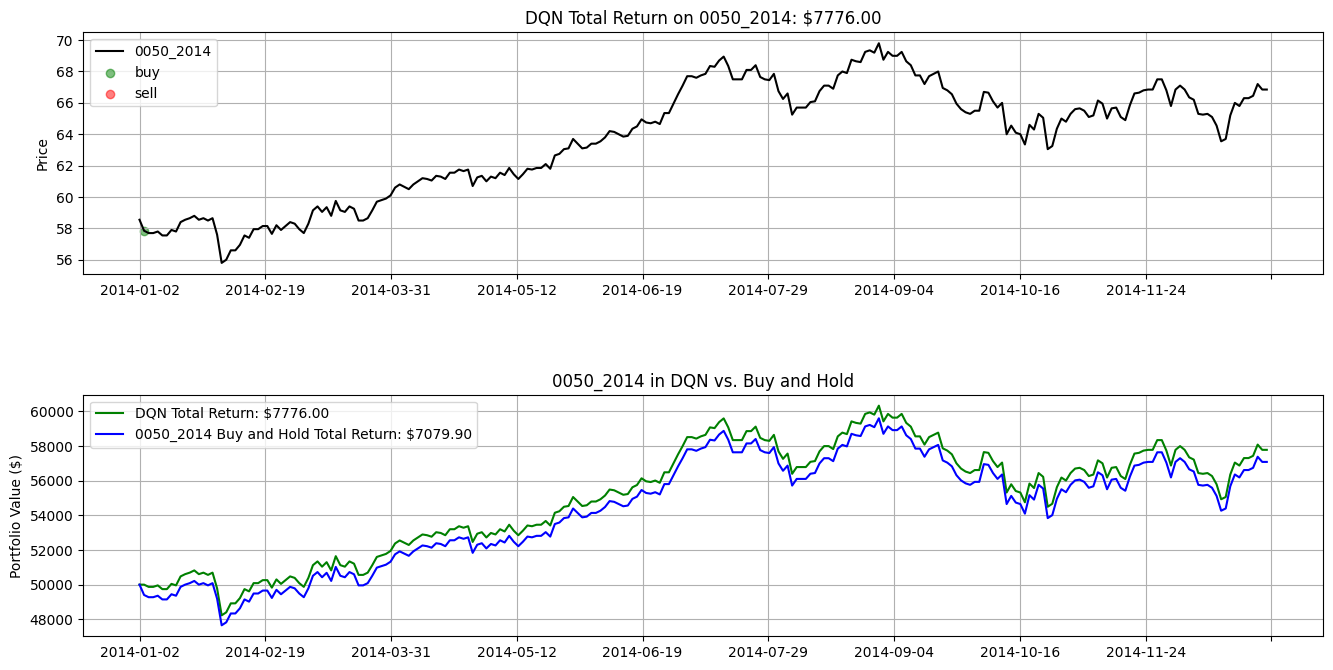

In [1]:

import argparse
import importlib
import logging
import sys
import os
import numpy as np
# np.random.seed(3)  # for reproducible Keras operations

from utility.action import *
from utility.utils import *


model_name = 'DQN'
stock_name = '0050_2014'
window_size = 10
num_episode = 5
initial_balance = 50000

stock_margin = stock_margins(stock_name)
display = True
window_size = 10
action_dict = {0: 'Hold', 1: 'Hold', 2: 'Sell'}

# select evaluation model
model = importlib.import_module(f'agents.{model_name}')
agent = model.Agent(state_dim=13+3, balance=initial_balance, is_eval=True, model_name=model_name)

# configure logging
logging.basicConfig(filename=f'logs/{model_name}_evaluation_{stock_name}.log', filemode='w',
                    format='[%(asctime)s.%(msecs)03d %(filename)s:%(lineno)3s] %(message)s', 
                    datefmt='%m/%d/%Y %H:%M:%S', level=logging.INFO)

# def buy(agent,stock_prices,t):
#     if agent.balance > stock_prices[t]:
#         # buy maximum stocks 
#         buy_num = int(agent.balance/stock_prices[t])
#         agent.balance -= stock_prices[t] * buy_num
#         agent.inventory.extend([stock_prices[t]]*buy_num)
#         agent.buy_dates.append(t)
#         reward=0
#         return f'Buy: ${stock_prices[t]:.2f}, {buy_num} stocks | Reward: ${reward:.2f}', reward
#     else:
#         reward=0
#         return f'Buy: no cash to buy | Reward: ${reward:.2f}', reward

# def sell(agent,stock_prices,t):
#     if len(agent.inventory) > 0:
#         sell_num = len(agent.inventory) #持有股數
#         sell_balance = stock_prices[t] * sell_num # 當日賣出總額
#         bought_balance = agent.inventory[0] * sell_num # 當初購買價格
#         reward = sell_balance - bought_balance
#         agent.balance += sell_balance
#         agent.inventory = []
#         agent.sell_dates.append(t)
#         return f'Sell: ${stock_prices[t]:.2f}, {sell_num} stocks | Reward: ${reward:.2f}', reward
#     else:
#         reward=0
#         return f'Sell: No stocks to sell | Reward: ${reward:.2f}', reward 


# def hold_eval():
#     return 'Hold'

portfolio_return = 0
while portfolio_return == 0: # a hack to avoid stationary case
    stock_prices = stock_close_prices(stock_name)
    trading_period = len(stock_prices) - 1
    state = generate_combined_state(0, window_size, stock_prices, stock_margin, agent.balance, len(agent.inventory)) 
    for t in range(1, trading_period + 1):
        if model_name == 'DDPG':
            actions = agent.act(state, t)
            action = np.argmax(actions)
        else:
            actions = agent.model.predict(state)[0]
            action = agent.act(state)

        # print(state)
        # print('actions:', action, actions)

        next_state = generate_combined_state(t, window_size, stock_prices, stock_margin, agent.balance, len(agent.inventory)) 
        previous_portfolio_value = len(agent.inventory) * stock_prices[t] + agent.balance
        
        # execute position
        logging.info(f'Step: {t}')
        if action != np.argmax(actions): logging.info(f"\t\t'{action_dict[action]}' is an exploration.")
        if action == 0: 
            execution_result = hold_eval() # hold
        if action == 1 and agent.balance > stock_prices[t]: 
            execution_result, reward,agent = buy(agent,stock_prices,t)  # buy
        if action == 2 and len(agent.inventory) > 0: 
            execution_result, reward,agent = sell(agent,stock_prices,t)        # sell

        logging.info(execution_result)    

        current_portfolio_value = len(agent.inventory) * stock_prices[t] + agent.balance
        agent.return_rates.append((current_portfolio_value - previous_portfolio_value) / previous_portfolio_value)
        agent.portfolio_values.append(current_portfolio_value)
        state = next_state

        done = True if t == trading_period else False
        if done:
            portfolio_return = evaluate_portfolio_performance(agent, logging)

if display:
    # plot_portfolio_transaction_history(stock_name, agent)
    # plot_portfolio_performance_comparison(stock_name, agent)
    plot_all(stock_name, agent)


In [2]:

df = pd.read_csv('./data/{}.csv'.format(stock_name))
buy_prices = [df.iloc[t, 4] for t in agent.buy_dates]
# buy_prices
agent.buy_dates

[1]

In [4]:
df

,Unnamed: 0,High,Low,Open,Close,Volume,Adj Close,MarginPurchaseBuy,MarginPurchaseCashRepayment,MarginPurchaseSell,...,ShortSaleSell,ShortSaleTodayBalance,ShortSaleYesterdayBalance,b_total,s_total,b_s_ratio,buy_volume,sell_volume,bs_ratio,Date
0,2014-01-02,58.750000,58.349998,58.700001,58.549999,10762073.0,58.549999,492.0,0.0,552.0,...,18.0,2393.0,2408.0,342192.0,345482.0,1.009612,6531000.0,1039000.0,6.285846,2014-01-02
1,2014-01-03,58.450001,57.700001,58.450001,57.849998,14509506.0,57.849998,699.0,2.0,406.0,...,54.0,2385.0,2393.0,341276.0,344865.0,1.010513,5260000.0,1312000.0,4.009143,2014-01-03
2,2014-01-06,57.950001,57.549999,57.750000,57.700001,14870810.0,57.700001,224.0,2.0,56.0,...,23.0,2372.0,2385.0,341110.0,344878.0,1.011043,7477000.0,2012000.0,3.716201,2014-01-06
3,2014-01-07,57.900002,57.700001,57.750000,57.700001,13128332.0,57.700001,295.0,5.0,279.0,...,10.0,2332.0,2372.0,341099.0,344918.0,1.011193,6194000.0,936000.0,6.617514,2014-01-07
4,2014-01-08,57.950001,57.700001,57.700001,57.799999,7605215.0,57.799999,437.0,0.0,75.0,...,5.0,2316.0,2332.0,340862.0,345059.0,1.012310,2232000.0,1749000.0,1.276157,2014-01-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243,2014-12-25,66.400002,66.150002,66.349998,66.300003,4417764.0,66.300003,38.0,0.0,121.0,...,52.0,1930.0,1905.0,279930.0,281945.0,1.007195,2576000.0,1333000.0,1.932482,2014-12-25
244,2014-12-26,66.500000,66.199997,66.349998,66.449997,21313397.0,66.449997,94.0,0.0,117.0,...,37.0,1955.0,1930.0,279953.0,281920.0,1.007023,18390000.0,18222000.0,1.009220,2014-12-26
245,2014-12-29,67.300003,66.550003,66.599998,67.199997,11101377.0,67.199997,141.0,0.0,324.0,...,45.0,1885.0,1918.0,280130.0,281990.0,1.006636,9669000.0,2630000.0,3.676424,2014-12-29
246,2014-12-30,67.449997,66.849998,67.150002,66.849998,8583907.0,66.849998,129.0,0.0,244.0,...,65.0,1892.0,1885.0,280245.0,281983.0,1.006198,5685000.0,2024000.0,2.808793,2014-12-30
